# pytorch实现手写数字识别

In [1]:
from torchvision import transforms
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch import optim

## 加载数据集

In [2]:
train_batch_size = 64
test_batch_size = 1000
img_size = 28

def get_dataloader(train=True):
    assert isinstance(train,bool),"train 必须是bool类型"

    #准备数据集，其中0.1307，0.3081为MNIST数据的均值和标准差，这样操作能够对其进行标准化
    #因为MNIST只有一个通道（黑白图片）,所以元组中只有一个值
    dataset = torchvision.datasets.MNIST('/data', train=train, download=True,
                                         transform=torchvision.transforms.Compose([
                                         torchvision.transforms.ToTensor(),
                                         torchvision.transforms.Normalize((0.1307,), (0.3081,)),]))
    #准备数据迭代器
    batch_size = train_batch_size if train else test_batch_size
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return dataloader

## 构建模型

### 全连接神经网络 Fully Connected Neural Network
当前一层的神经元和前一层的神经元相互链接，其核心操作就是$y = wx$，即矩阵的乘法，实现对前一层的数据的变换

模型的构建使用了一个三层的神经网络，其中包括两个全连接层和一个输出层，第一个全连接层会经过激活函数的处理，将处理后的结果交给下一个全连接层，进行变换后输出结果

那么在这个模型中有两个地方需要注意：

1. 激活函数如何使用
2. 每一层数据的形状
3. 模型的损失函数

### Relu激活函数
前面介绍了激活函数的作用，这里使用的激活函数为Relu，
Relu激活函数由`import torch.nn.functional as F`提供，`F.relu(x)`即可对x进行处理

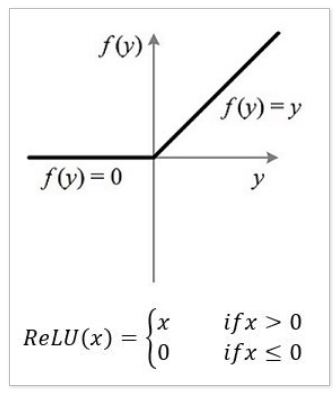

In [3]:
# 测试relu
test_relu_data = torch.tensor([-2, -1,  0,  1,  2])
F.relu(test_relu_data)

tensor([0, 0, 0, 1, 2])

### 模型的网络结构
1. 原始输入数据为的形状:`[batch_size,1,28,28]`
2. 进行形状的修改：`[batch_size,28*28]` ,(全连接层是在进行矩阵的乘法操作)
3. 第一个全连接层的输出形状：`[batch_size,28]`，这里的28是个人设定的，你也可以设置为别的
4. 激活函数不会修改数据的形状
5. 第二个全连接层的输出形状：`[batch_size,10]`,因为手写数字有10个类别


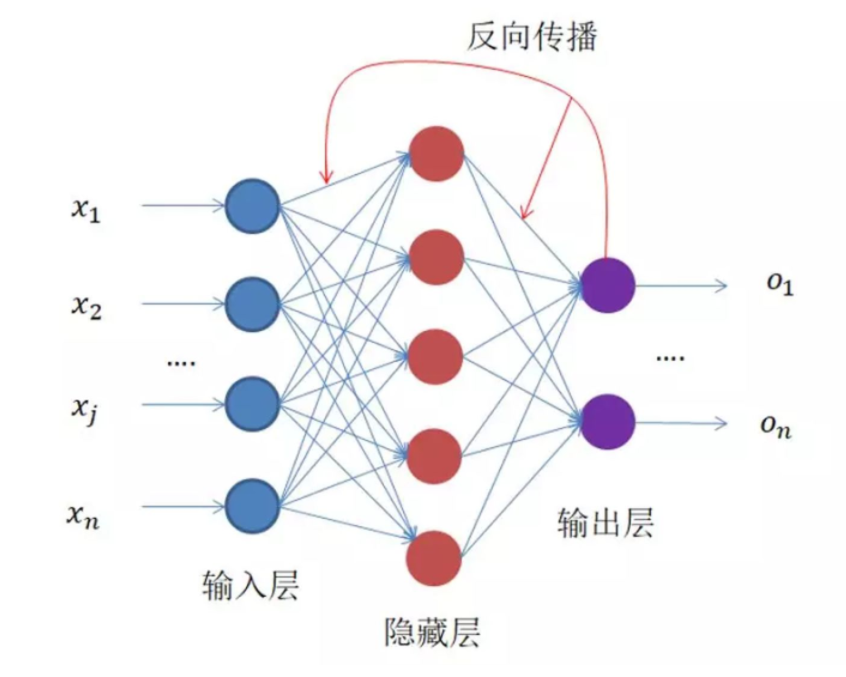

In [4]:
class MnistNet(torch.nn.Module):
    def __init__(self):
        super(MnistNet,self).__init__()
        self.fc1 = torch.nn.Linear(28*28*1,28)
        self.fc2 = torch.nn.Linear(28,10)

    def forward(self,x):
        x = x.view(-1,28*28*1)
        x = self.fc1(x) #[batch_size,28]
        x = F.relu(x)  #[batch_size,28]
        x = self.fc2(x) #[batch_size,10]
        # return x
        return F.log_softmax(x,dim=-1)

## 训练模型

首先，我们需要明确，当前我们手写字体识别的问题是一个多分类的问题，所谓多分类对比的是之前学习的2分类

回顾之前的课程，我们在逻辑回归中，我们使用sigmoid进行计算对数似然损失，来定义我们的2分类的损失。

- 在2分类中我们有正类和负类，正类的概率为$P(x) =  \frac{1}{1+e^{-x}} = \frac{e^x}{1+e^x}$,那么负类的概率为$1-P(x)$

- 将这个结果进行计算对数似然损失$-\sum y log(P(x))$就可以得到最终的损失






那么在多分类的过程中我们应该怎么做呢？

- 多分类和2分类中唯一的区别是我们不能够再使用sigmoid函数来计算当前样本属于某个类别的概率，而应该使用softmax函数。

- softmax和sigmoid的区别在于我们需要去计算样本属于每个类别的概率，需要计算多次，而sigmoid只需要计算一次

softmax的公式如下：
$$
\sigma(z)_j = \frac{e^{z_j}}{\sum^K_{k=1}e^{z_K}}  ,j=1 \cdots k
$$

例如下图：
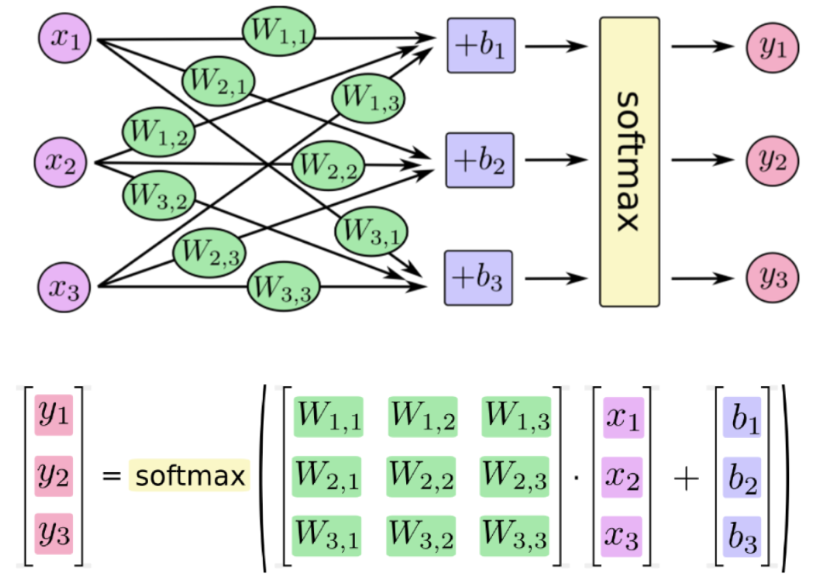




假如softmax之前的输出结果是`2.3, 4.1, 5.6`,那么经过softmax之后的结果是多少呢？
$$
Y1 = \frac{e^{2.3}}{e^{2.3}+e^{4.1}+e^{5.6}} \\
Y2 = \frac{e^{4.1}}{e^{2.3}+e^{4.1}+e^{5.6}} \\
Y3 = \frac{e^{5.6}}{e^{2.3}+e^{4.1}+e^{5.6}} \\
$$


对于这个softmax输出的结果，是在[0,1]区间，我们可以把它当做概率




和前面2分类的损失一样，多分类的损失只需要再把这个结果进行对数似然损失的计算即可

即：
$$
\begin{align*}
& J = -\sum Y log(P) &, 其中 P = \frac{e^{z_j}}{\sum^K_{k=1}e^{z_K}} ,Y表示真实值
\end{align*}
$$
最后，会计算每个样本的损失，即上式的平均值

我们把softmax概率传入对数似然损失得到的损失函数称为**交叉熵损失**


在pytorch中有两种方法实现交叉熵损失

1. ```
   criterion = nn.CrossEntropyLoss()
   loss = criterion(input,target)
   ```

2. ```
   #1. 对输出值计算softmax和取对数
   output = F.log_softmax(x,dim=-1)
   #2. 使用torch中带权损失
   loss = F.nll_loss(output,target)
   ```

带权损失定义为：$l_n = -\sum w_{i} x_{i}$，其实就是把$log(P)$作为$x_i$,把真实值Y作为权重

训练的流程：

1. 实例化模型，设置模型为训练模式
2. 实例化优化器类，实例化损失函数
3. 获取，遍历dataloader
4. 梯度置为0
5. 进行向前计算
6. 计算损失
7. 反向传播
8. 更新参数

In [5]:
mnist_net = MnistNet()
optimizer = torch.optim.Adam(mnist_net.parameters(),lr= 0.001)
# criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
train_loss_list = []
train_count_list = []

def train(epoch):
    mnist_net.train(True)
    train_dataloader = get_dataloader(True)
    for idx,(data,target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = mnist_net(data)
        loss = F.nll_loss(output,target) #对数似然损失
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,  idx * len(data), len(train_dataloader.dataset),100. * idx / len(train_dataloader), loss.item()))
            train_loss_list.append(loss.item())
            train_count_list.append(idx*train_batch_size+(epoch-1)*len(train_dataloader))

In [6]:
epoch = 1
for i in range(epoch): #模型训练5轮
    train(i)
#     test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.339646
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.414023
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.227812
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.289011
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.237807
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.172365
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.404535
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.222226
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.380804
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.217790


## 评估结果

评估的过程和训练的过程相似，但是：

1. 不需要计算梯度
2. 需要收集损失和准确率，用来计算平均损失和平均准确率
3. 损失的计算和训练时候损失的计算方法相同
4. 准确率的计算：
   - 模型的输出为[batch_size,10]的形状
   - 其中最大值的位置就是其预测的目标值（预测值进行过sotfmax后为概率，sotfmax中分母都是相同的，分子越大，概率越大）
   - 最大值的位置获取的方法可以使用`torch.max`,返回最大值和最大值的位置
   - 返回最大值的位置后，和真实值（`[batch_size]`）进行对比，相同表示预测成功

In [7]:
def test():
    test_loss = 0
    correct = 0
    mnist_net.eval()
    test_dataloader = get_dataloader(train=False)
    with torch.no_grad():
        for data, target in test_dataloader:
            output = mnist_net(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1] #获取最大值的位置,[batch_size,1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_dataloader.dataset)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

In [8]:
test()


Test set: Avg. loss: 0.2397, Accuracy: 9292/10000 (92.92%)



## 模型的保存和加载

### 模型的保存

In [9]:
torch.save(mnist_net.state_dict(),"model/mnist_net.pt") #保存模型参数
torch.save(optimizer.state_dict(), 'results/mnist_optimizer.pt') #保存优化器参数

### 模型的加载

In [10]:
mnist_net.load_state_dict(torch.load("model/mnist_net.pt"))
optimizer.load_state_dict(torch.load("results/mnist_optimizer.pt"))